# LIM forecasting: Sea ice 

Katie Brennan  
started March 31, 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")

In [266]:
# Define of the name of the variable to use for the LIM
#var_to_extract = 'tas'
# tos is not working due to mask issues...
var_to_extract = 'sic'

# number of EOFs to retain for the LIM state vector
nmodes = 20

# forecast lead time in months that defines the LIM training
tau = 3

# training data defined by the first ntrain times
ntrain = 4000

# for the LIM readme
data_source = 'CCSM4 last millennium simulation'

In [206]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
import ESMF
import LMR_utils
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point

In [259]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as uLIM

In [281]:
import importlib
importlib.reload(uLIM)

<module 'LIM_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py'>

In [271]:
import time as timestamp # avoids conflict with local naming!

In [272]:
pi = np.pi

# fill continents if plotting SST; otherwise no
if var_to_extract == 'tos':
    noland = True
else:
    noland = False
    
# netcdf file locations
#ccsm_dir = '/Users/hakim/data/LMR_python3/data/model/ccsm4_last_millenium/'
ccsm_dir = '/home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/'

infile_ccsm_sic = (ccsm_dir + 'sic_sfc_OImon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_tos = (ccsm_dir + 'tos_sfc_Omon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_tas = (ccsm_dir + 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_z500 = (ccsm_dir + 'zg_500hPa_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_pr = (ccsm_dir + 'pr_sfc_Amon_CCSM4_past1000_085001-185012.nc')

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

In [273]:
#----------- end of function definitions --------------

In [274]:
#
# load CCSM4 past1000 data...
#
# data_in_tas,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_tas, 45, 72)
# data_in_z500,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_z500, 45, 72)
# data_in_pr,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_pr, 45, 72)
data_in_sic,lat_2d,lon_2d = uLIM.get_data(var_to_extract,infile_ccsm_sic, 45, 72)

ntime = data_in_sic.shape[0]
nlat = data_in_sic.shape[1]
nlon = data_in_sic.shape[2]

fetching  sic  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 19.61206078529358 seconds
-----------------------------------------------------
(12012, 180, 360)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 180
nlon: 360
(64800, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 2.7695391178131104 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [275]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_in_sic,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_in_sic.shape))
print('Shape of X: '+str(X.shape))

Original shape: (12012, 45, 72)
Shape of X: (3240, 12012)


In [276]:
X_nonan = np.where(np.isnan(X.data),0,X.data)
X_nonan_arctic = X_nonan
X_nonan_arctic[np.where(lat_2d.reshape(nlat*nlon)<0),:] = 0

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


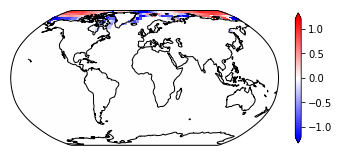

In [277]:
uLIM.plot_map_vector(X_nonan_arctic[:,800].data,lat_2d,lon_2d)

In [279]:
u,s,v,W = uLIM.calc_eof(X_nonan, lat_2d)

computing EOFs...
-----------------------------------------------------
completed in 24.541040658950806 seconds
-----------------------------------------------------
(3240, 3240) (3240,) (3240, 12012)


In [113]:
# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*X_nonan_arctic))

checking svd (success for True response)...
True


100.00000000000003
fraction in first  20  EOFs =  52.75923306593896


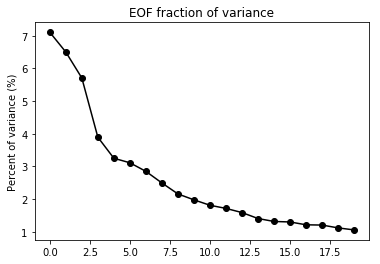

In [282]:
uLIM.plot_eigenvalues(s,nmodes,var_to_extract)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


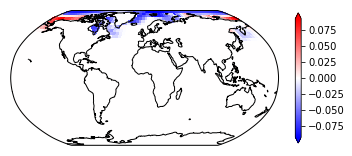

In [115]:
uLIM.plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [120]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,X_nonan_arctic)

20.840946530053486
(3240, 12012)


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


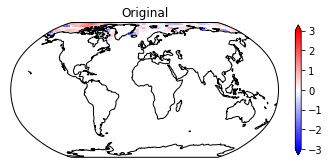

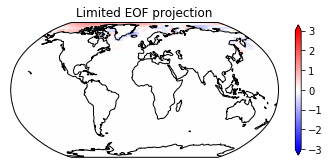

In [123]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

uLIM.plot_map_vector(X_nonan_arctic[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Original')
plt.show()
uLIM.plot_map_vector(check[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Limited EOF projection')
plt.show()

In [124]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [125]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (20, 4000)
validation data shape:  (20, 8012)


In [126]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [244]:
# train the LIM
LIMd = uLIM.LIM_train(tau,x_train)

In [245]:
lags

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [246]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(13)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = uLIM.LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = uLIM.LIM_forecast(LIMd,x_valid,lags,E)

t= 0


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


t= 1


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [247]:
LIMfd_train.keys()

dict_keys(['error', 'x_forecast', 'x_truth_phys_space', 'x_forecast_phys_space'])

In [248]:
LIMfd_train_error_3d.shape

(45, 72, 13)

In [249]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_error_3d = np.reshape(LIMfd_train['error'],[nlat,nlon,ntims])
LIMfd_valid_error_3d = np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims])

[train_gm_err,
 train_nh_err,
 train_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_train_error_3d,-1,0),lat_2d[:,0])
[train_gm_var,
 train_nh_var,
 train_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
[valid_gm_err,
 valid_nh_err,
 valid_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_valid_error_3d,-1,0),lat_2d[:,0])
[valid_gm_var,
 valid_nh_var,
 valid_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

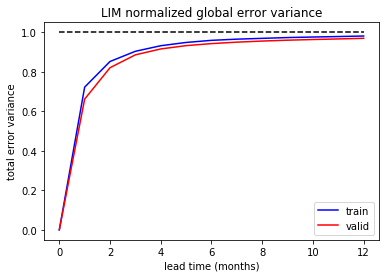

In [250]:
# plot global-mean normalized error variance
plt.plot(lags,train_nh_err/train_nh_var,'b-',label='train')
plt.plot(lags,valid_nh_err/valid_nh_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_error_growth_1_6_12months',dpi=300)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


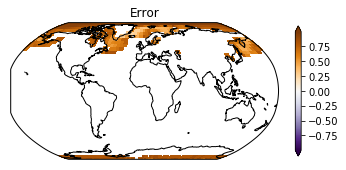

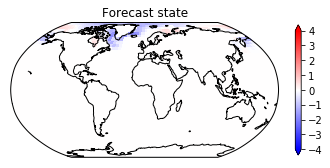

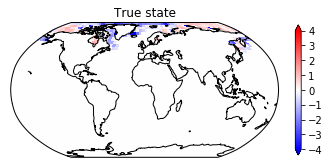

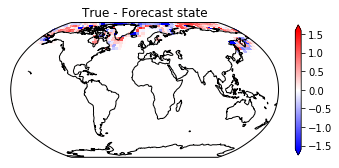

In [251]:
# plot maps of select forecasts and errors for a chosen lag in months (and time, itime)
ilag = 1
plot_map_vector(LIMfd_train['error'][:,ilag]/train_var,lat_2d,lon_2d,cmap='PuOr_r')
plt.title('Error')
plt.show()
itime = 1
plot_map_vector(np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d,minv=-4,maxv=4 )
plt.title('Forecast state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime],lat_2d,lon_2d,minv=-4,maxv=4)
plt.title('True state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime] -np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d)
plt.title('True - Forecast state')
plt.show()

In [252]:
forecast_state_train = np.matmul(E,LIMfd_train['x_forecast']) 
true_state_train = X_nonan_arctic[:,train_inds]
true_state_train.shape, forecast_state_train.shape

((3240, 4000), (13, 3240, 4000))

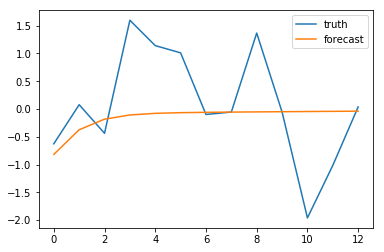

In [253]:
initialt = 1
plt.plot(np.arange(0,13,1),true_state_train[3200,initialt:initialt+13], label='truth')
plt.plot(np.arange(0,13,1),forecast_state_train[:,3200,initialt], label='forecast')
plt.legend()

r = np.zeros(4000-12)

for it in range(4000-12):
    r[it] = np.corrcoef(true_state_train[3000,it:it+13],forecast_state_train[:,3000,it])[0,1]

0.15253532016871182

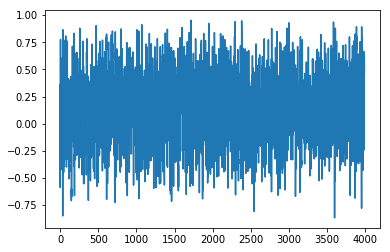

In [254]:
plt.plot(r)
#plt.xlim(3900,4000)
r.mean()

In [142]:
LIMfd_train.keys(), x_valid.shape, E.shape, lags

(dict_keys(['error', 'x_forecast', 'x_truth_phys_space', 'x_forecast_phys_space']),
 (20, 8012),
 (3240, 20),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

In [138]:
LIMfd_train['x_truth_phys_space'].shape,LIMfd_train['x_forecast_phys_space'].shape, LIMfd_train['error'].shape, LIMfd_train['x_forecast'].shape

((3240, 3988), (3240, 3988), (3240, 13), (13, 20, 4000))

In [145]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_truth_3d = np.reshape(LIMfd_train['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_train_forecast_3d = np.reshape(LIMfd_train['x_forecast_phys_space'],[nlat,nlon,3988])
LIMfd_valid_truth_3d = np.reshape(LIMfd_valid['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_valid_forecast_3d = np.reshape(LIMfd_valid['x_forecast_phys_space'],[nlat,nlon,3988])

[train_truth_gm,
 train_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_truth_3d,lat_2d[:,0])
[train_forecast_gm,
 train_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_forecast_3d,lat_2d[:,0])
[valid_truth_gm,
 valid_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_truth_3d,lat_2d[:,0])
[valid_forecast_gm,
 valid_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_forecast_3d,lat_2d[:,0])



ValueError: cannot reshape array of size 25920000 into shape (45,72,3988)

## Independent validation: 

In [39]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas, 45, 72)
ntime_20cr = data_20cr.shape[0]

fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc
-----------------------------------------------------
completed in 0.7526452541351318 seconds
-----------------------------------------------------
(1932, 91, 180)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 91
nlon: 180
(16380, 1932)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 0.3795194625854492 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [41]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [43]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

t= 0
t= 1


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [44]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

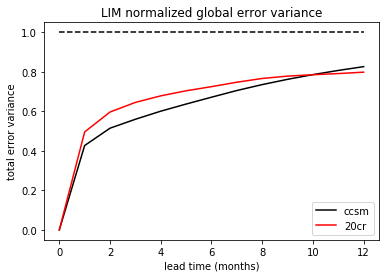

In [45]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)